<a href="https://colab.research.google.com/github/starryMagician/myDL-jobs/blob/main/DeepLearning/svrg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cifar10 with SGD

## Get Data

In [111]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import time

In [209]:
# Get Data
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
batch_size = 500
num_epoch = 10
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## SGD + SVRG implementation

In [210]:
def svrg_update(net, full_optimizer, X, y):
    full_optimizer.zero_grad()  # compute full grad
    y_pred = net(X)
    loss = criterion(y_pred, y)
    loss.backward()
    full_grad = [param.grad.clone() for param in net.parameters()]

    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    optimizer.zero_grad()
    y_pred = net(X)
    loss = criterion(y_pred, y)
    loss.backward()
    for (param, f_grad) in zip(net.parameters(), full_grad):
        mean = torch.mean(f_grad, dim=0) # compute expectation
        # print("mean",mean)
        f_grad_mean = torch.zeros_like(f_grad)
        for row in range(len(f_grad_mean)):
          f_grad_mean[row] = mean
        # print(f_grad_mean)
        param.grad = param.grad - f_grad + f_grad_mean

    return loss, optimizer, net

## train 1

In [212]:
# Train
m = 20  # record running loss for each m batches
def trainNN(gradient_method, net, optimizer, criterion):
  lossLst = list()
  time0 = time.time()
  for epoch in range(num_epoch):
      running_loss = 0.0

      if gradient_method == "sgd":
        for i, data in enumerate(trainloader, 0):
            X, y = data
            optimizer.zero_grad()
            y_pred = net(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % m == (m-1):  # record running loss for each 50 minibatches
              lossLst.append(running_loss / m)
              running_loss = 0.0

      elif gradient_method == "svrg":
        for i, data in enumerate(trainloader, 0):
          X, y = data
          loss, optimizer, net = svrg_update(net, optimizer, X, y)
          optimizer.step() # update grad
          running_loss += loss.item()
          if i % m == (m-1):
            lossLst.append(running_loss / m)
            running_loss = 0.0

  print("[Training Done]")
  return lossLst, time.time()-time0

### 1-layer MLP

In [213]:
# 1层MLP
class MLP_1(nn.Module):
    def __init__(self):
        super(MLP_1, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 10)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = self.fc1(x)
        return x


# Run training
net = MLP_1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
loss_sgd, time_sgd = trainNN("sgd", net, optimizer, criterion)
loss_svrg, time_svrg = trainNN("svrg", net, optimizer, criterion)

[Training Done]
[Training Done]


Final loss with pure SGD: 1.6811734974384307 Runing time: 149.74898171424866
Final loss with SGD + svrg: 1.6433429419994354 Runing time: 150.00339698791504


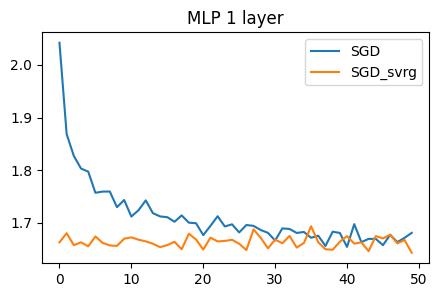

In [214]:
# Plot train loss curves
plt.figure(figsize=(5,3))
print("Final loss with pure SGD:",loss_sgd[-1], "Runing time:",time_sgd)
ax = sns.lineplot(data=loss_sgd, label="SGD")
print("Final loss with SGD + svrg:", loss_svrg[-1], "Runing time:",time_svrg)
sns.lineplot(data=loss_svrg, label="SGD_svrg", ax=ax)
ax.legend()
plt.title("MLP 1 layer")
plt.show()

# plt.figure(figsize=(5,3))
# ax2 = sns.lineplot(data=loss_svrg, label="SGD_svrg")
# plt.show()

### 2-layer MLP

In [215]:
# 2层MLP
class MLP_2(nn.Module):
    def __init__(self):
        super(MLP_2, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Run training
net = MLP_2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_sgd, time_sgd = trainNN("sgd", net, optimizer, criterion)
loss_svrg, time_svrg = trainNN("svrg", net, optimizer, criterion)

[Training Done]
[Training Done]


Final loss with pure SGD: 1.6829089045524597 Running Time: 158.20528960227966
Final loss with SGD + svrg: 1.6906038045883178 Running Time: 174.4583945274353


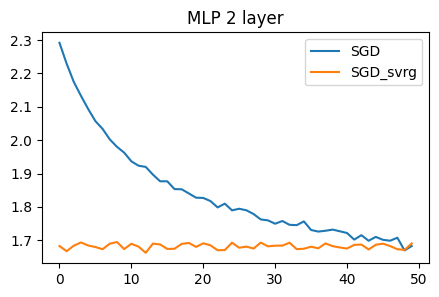

In [216]:
# Plot train loss curves
plt.figure(figsize=(5,3))
print("Final loss with pure SGD:", loss_sgd[-1], "Running Time:", time_sgd)
ax = sns.lineplot(data=loss_sgd, label="SGD")
print("Final loss with SGD + svrg:", loss_svrg[-1], "Running Time:", time_svrg)
sns.lineplot(data=loss_svrg, label="SGD_svrg", ax=ax)
ax.legend()
plt.title("MLP 2 layer")
plt.show()

### 4-layer MLP

In [217]:
# 4层MLP
class MLP_4(nn.Module):
    def __init__(self):
        super(MLP_4, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# Run training
net = MLP_4()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
loss_sgd, time_sgd = trainNN("sgd", net, optimizer, criterion)
loss_svrg, time_svrg = trainNN("svrg", net, optimizer, criterion)

[Training Done]
[Training Done]


Final loss with pure SGD: 1.30911825299263 Running Time: 159.36375832557678
Final loss with SGD + svrg: 1.2413824677467347 Running Time: 180.11368083953857


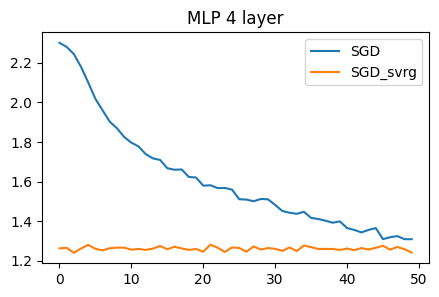

In [218]:
# Plot train loss curves
plt.figure(figsize=(5,3))
print("Final loss with pure SGD:", loss_sgd[-1], "Running Time:", time_sgd)
ax = sns.lineplot(data=loss_sgd, label="SGD")
print("Final loss with SGD + svrg:", loss_svrg[-1], "Running Time:", time_svrg)
sns.lineplot(data=loss_svrg, label="SGD_svrg", ax=ax)
ax.legend()
plt.title("MLP 4 layer")
plt.show()

## train 2

In [307]:
# Get Data
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
batch_size = 500
num_epoch = 5
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [308]:
# Train2
m = 10  # record running loss for each m batches
def trainNN(gradient_method, net, optimizer, criterion, num_layer):
  lossLst = list()
  time0 = time.time()
  for epoch in range(num_epoch):
      running_loss = 0.0

      if gradient_method == "sgd":
        for i, data in enumerate(trainloader, 0):
            X, y = data
            optimizer.zero_grad()
            y_pred = net(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % m == (m-1):  # record running loss for each 50 minibatches
              lossLst.append(running_loss / m)
              running_loss = 0.0

      elif gradient_method == "svrg":
        gradients_w, gradients_b = [], []
        full_grad_mean = 0
        for i, data in enumerate(trainloader, 0):
            X, y = data
            optimizer.zero_grad()
            y_pred = net(X)
            loss = criterion(y_pred, y)
            loss.backward()
            param_idx = 0
            for param in net.parameters():
              if full_grad_mean == 0:  # 1-st iter
                if len(param.grad.shape) > 1:
                  gradients_w.append(param.grad)
                else:
                  gradients_b.append(param.grad)
              else:  # after 1-st iter
                layer_idx = int(param_idx / num_layer)
                if len(param.grad.shape) > 1:
                  f_grad = gradients_w
                  param.grad = param.grad - f_grad[i, layer_idx] + full_grad_mean[param_idx]  # modify gradient
                  gradients_w.append(param.grad)
                else:
                  f_grad = gradients_b
                  param.grad = param.grad - f_grad[i, layer_idx] + full_grad_mean[param_idx]  # modify gradient
                  gradients_b.append(param.grad)
              param_idx += 1

            optimizer.step() # update with modified gradients
            running_loss += loss.item()
            if i % m == (m-1):  # record running loss for each 50 minibatches
              lossLst.append(running_loss / m)
              running_loss = 0.0

        gradients_w = np.array(gradients_w).reshape((i+1, num_layer))  # dim = (#batches, #layers)
        gradients_b = np.array(gradients_b).reshape((i+1, num_layer))
        full_grad_w = list(np.sum(gradients_w, axis=0))  # len = #layers
        full_grad_b = list(np.sum(gradients_b, axis=0))
        full_grad_mean = []
        for n in range(num_layer):
          full_grad_mean.append(torch.div(full_grad_w[n], i+1)) # compute new expectation of full gradient
          full_grad_mean.append(torch.div(full_grad_b[n], i+1)) # len = 2 * #layers

  print("[Training Done]")
  return lossLst, time.time()-time0

### Run on 1-layer MLP

In [309]:
# 1层MLP
class MLP_1(nn.Module):
    def __init__(self):
        super(MLP_1, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 10)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = self.fc1(x)
        return x

# Run training
net = MLP_1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
loss_sgd, time_sgd = trainNN("sgd", net, optimizer, criterion, 1)
loss_svrg, time_svrg = trainNN("svrg", net, optimizer, criterion, 1)

[Training Done]


<ipython-input-308-efbb1f9fbcdd>:56: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients_w = np.array(gradients_w).reshape((i+1, num_layer))  # dim = (#batches, #layers)
<ipython-input-308-efbb1f9fbcdd>:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gradients_w = np.array(gradients_w).reshape((i+1, num_layer))  # dim = (#batches, #layers)
<ipython-input-308-e

[Training Done]


Final loss with pure SGD: 1.7260058045387268 Runing time: 75.73754930496216
Final loss with SGD + svrg: 1.6612316370010376 Runing time: 74.93412256240845


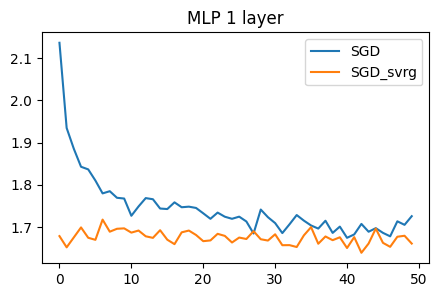

In [310]:
# Plot train loss curves
plt.figure(figsize=(5,3))
print("Final loss with pure SGD:",loss_sgd[-1], "Runing time:",time_sgd)
ax = sns.lineplot(data=loss_sgd, label="SGD")
print("Final loss with SGD + svrg:", loss_svrg[-1], "Runing time:",time_svrg)
sns.lineplot(data=loss_svrg, label="SGD_svrg", ax=ax)
ax.legend()
plt.title("MLP 1 layer")
plt.show()

# plt.figure(figsize=(5,3))
# ax2 = sns.lineplot(data=loss_svrg, label="SGD_svrg")
# plt.show()

### Run on 2-layer MLP

In [311]:
# 2层MLP
class MLP_2(nn.Module):
    def __init__(self):
        super(MLP_2, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Run training
net = MLP_2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_sgd, time_sgd = trainNN("sgd", net, optimizer, criterion, 2)
loss_svrg, time_svrg = trainNN("svrg", net, optimizer, criterion, 2)

[Training Done]


<ipython-input-308-efbb1f9fbcdd>:56: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients_w = np.array(gradients_w).reshape((i+1, num_layer))  # dim = (#batches, #layers)
<ipython-input-308-efbb1f9fbcdd>:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gradients_w = np.array(gradients_w).reshape((i+1, num_layer))  # dim = (#batches, #layers)
<ipython-input-308-e

[Training Done]


Final loss with pure SGD: 1.8020121574401855 Running Time: 80.29101037979126
Final loss with SGD + svrg: 1.6843167304992677 Running Time: 84.42973518371582


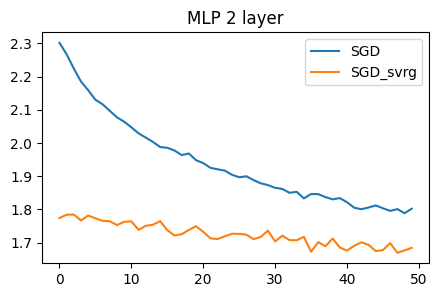

In [312]:
# Plot train loss curves
plt.figure(figsize=(5,3))
print("Final loss with pure SGD:", loss_sgd[-1], "Running Time:", time_sgd)
ax = sns.lineplot(data=loss_sgd, label="SGD")
print("Final loss with SGD + svrg:", loss_svrg[-1], "Running Time:", time_svrg)
sns.lineplot(data=loss_svrg, label="SGD_svrg", ax=ax)
ax.legend()
plt.title("MLP 2 layer")
plt.show()

### Run on 4-layer MLP

In [313]:
# 4层MLP
class MLP_4(nn.Module):
    def __init__(self):
        super(MLP_4, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# Run training
net = MLP_4()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
loss_sgd, time_sgd = trainNN("sgd", net, optimizer, criterion, 4)
loss_svrg, time_svrg = trainNN("svrg", net, optimizer, criterion, 4)

[Training Done]


<ipython-input-308-efbb1f9fbcdd>:56: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients_w = np.array(gradients_w).reshape((i+1, num_layer))  # dim = (#batches, #layers)
<ipython-input-308-efbb1f9fbcdd>:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gradients_w = np.array(gradients_w).reshape((i+1, num_layer))  # dim = (#batches, #layers)
<ipython-input-308-e

[Training Done]


Final loss with pure SGD: 1.5302790641784667 Running Time: 80.82273960113525
Final loss with SGD + svrg: 1.3202922821044922 Running Time: 83.8621654510498


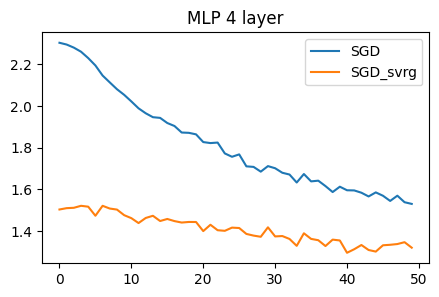

In [321]:
# Plot train loss curves
plt.figure(figsize=(5,3))
print("Final loss with pure SGD:", loss_sgd[-1], "Running Time:", time_sgd)
ax = sns.lineplot(data=loss_sgd, label="SGD")
print("Final loss with SGD + svrg:", loss_svrg[-1], "Running Time:", time_svrg)
sns.lineplot(data=loss_svrg, label="SGD_svrg", ax=ax)
ax.legend()
plt.title("MLP 4 layer")
plt.show()

# Cifar10 with Adam

In [315]:
# Get Data
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
batch_size = 500
num_epoch = 5
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [316]:
def adam_svrg(net, full_optimizer, X, y):
    full_optimizer.zero_grad()  # compute full grad
    y_pred = net(X)
    loss = criterion(y_pred, y)
    loss.backward()
    full_grad = [param.grad.clone() for param in net.parameters()]

    optimizer = optim.Adam(net.parameters(), lr=0.01)
    optimizer.zero_grad()
    y_pred = net(X)
    loss = criterion(y_pred, y)
    loss.backward()
    for (param, f_grad) in zip(net.parameters(), full_grad):
        mean = torch.mean(f_grad, dim=0) # compute expectation
        # print("mean",mean)
        f_grad_mean = torch.zeros_like(f_grad)
        for row in range(len(f_grad_mean)):
          f_grad_mean[row] = mean
        # print(f_grad_mean)
        param.grad = param.grad - f_grad + f_grad_mean

    return loss, optimizer, net

In [317]:
# Train
m = 10  # record running loss for each m batches
def trainNN_adam(gradient_method, net, optimizer, criterion):
  lossLst = list()
  time0 = time.time()
  for epoch in range(num_epoch):
      running_loss = 0.0

      if gradient_method == "adam":
        for i, data in enumerate(trainloader, 0):
            X, y = data
            optimizer.zero_grad()
            y_pred = net(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % m == (m-1):  # record running loss for each 50 minibatches
              lossLst.append(running_loss / m)
              running_loss = 0.0

      elif gradient_method == "adam_svrg":
        for i, data in enumerate(trainloader, 0):
          X, y = data
          loss, optimizer, net = adam_svrg(net, optimizer, X, y)
          optimizer.step()
          running_loss += loss.item()
          if i % m == (m-1):
            lossLst.append(running_loss / m)
            running_loss = 0.0

  print("[Training Done]")
  return lossLst, time.time()-time0

In [318]:
# Train2
m = 10  # record running loss for each m batches
def trainNN_adam(gradient_method, net, optimizer, criterion, num_layer):
  lossLst = list()
  time0 = time.time()
  for epoch in range(num_epoch):
      running_loss = 0.0

      if gradient_method == "adam":
        for i, data in enumerate(trainloader, 0):
            X, y = data
            optimizer.zero_grad()
            y_pred = net(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % m == (m-1):  # record running loss for each 50 minibatches
              lossLst.append(running_loss / m)
              running_loss = 0.0

      elif gradient_method == "adam_svrg":
        gradients_w, gradients_b = [], []
        full_grad_mean = 0
        for i, data in enumerate(trainloader, 0):
            X, y = data
            optimizer.zero_grad()
            y_pred = net(X)
            loss = criterion(y_pred, y)
            loss.backward()
            param_idx = 0
            for param in net.parameters():
              # print(param.grad.shape)
              if full_grad_mean == 0:  # 1-st iter
                if len(param.grad.shape) > 1:
                  gradients_w.append(param.grad)
                else:
                  gradients_b.append(param.grad)
              else:  # after 1-st iter
                if len(param.grad.shape) > 1:
                  f_grad = gradients_w
                  # full_grad_mean = full_grad_w
                  param.grad = param.grad - f_grad[i] + full_grad_mean[param_idx]  # modify gradient
                  gradients_w.append(param.grad)
                else:
                  f_grad = gradients_b
                  # full_grad_mean = full_grad_b
                  param.grad = param.grad - f_grad[i] + full_grad_mean[param_idx]  # modify gradient
                  gradients_b.append(param.grad)
              param_idx += 1

            optimizer.step() # update with modified gradients
            running_loss += loss.item()
            if i % m == (m-1):  # record running loss for each 50 minibatches
              lossLst.append(running_loss / m)
              running_loss = 0.0

        gradients_w = np.array(gradients_w).reshape((i+1, num_layer))  # dim = (#batches, #layers)
        gradients_b = np.array(gradients_b).reshape((i+1, num_layer))
        full_grad_w = list(np.sum(gradients_w, axis=0))  # len = #layers
        full_grad_b = list(np.sum(gradients_b, axis=0))
        full_grad_mean = []
        for n in range(num_layer):
          full_grad_mean.append(torch.div(full_grad_w[n], i+1)) # compute new expectation of full gradient
          full_grad_mean.append(torch.div(full_grad_b[n], i+1)) # len = 2 * #layers

  print("[Training Done]")
  return lossLst, time.time()-time0

Run on 1-layer MLP

In [319]:
# Run training
net = MLP_1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_adam, time_adam = trainNN_adam("adam", net, optimizer, criterion, 1)
loss_adam_svrg, time_adam_svrg = trainNN_adam("adam_svrg", net, optimizer, criterion, 1)

[Training Done]


<ipython-input-318-8c469d10a578>:58: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients_w = np.array(gradients_w).reshape((i+1, num_layer))  # dim = (#batches, #layers)
<ipython-input-318-8c469d10a578>:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gradients_w = np.array(gradients_w).reshape((i+1, num_layer))  # dim = (#batches, #layers)
<ipython-input-318-8

[Training Done]


Final loss with pure Adam: 1.703350055217743 Runing time: 74.35110759735107
Final loss with Adam + svrg: 1.6701688885688781 Runing time: 74.66761422157288


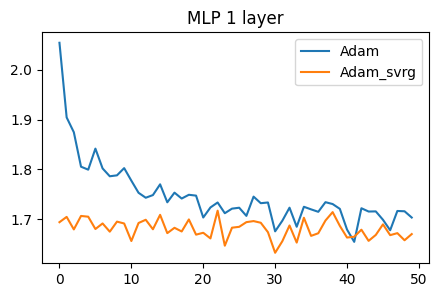

In [320]:
# Plot train loss curves
plt.figure(figsize=(5,3))
print("Final loss with pure Adam:",loss_adam[-1], "Runing time:",time_adam)
ax = sns.lineplot(data=loss_adam, label="Adam")
print("Final loss with Adam + svrg:", loss_adam_svrg[-1], "Runing time:",time_adam_svrg)
sns.lineplot(data=loss_adam_svrg, label="Adam_svrg", ax=ax)
ax.legend()
plt.title("MLP 1 layer")
plt.show()